In [ ]:
#%% IMPORT LIBRARIES

#import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import gpboost as gpb #https://github.com/fabsig/GPBoost/tree/master; https://github.com/fabsig/GPBoost/blob/master/examples/python-guide/GPBoost_algorithm.py
import time

#%% Set seaborn theme and random state
sns.set_theme(context='paper', style = 'ticks',font_scale=1.2)
rs = 621

In [76]:
# #read csv
df = pd.read_csv("CH4_ML_dataset_1d.csv")
# # #filter outlier ch4
df = df[df['CH4_flux'] < 2000]

# #remove chamber data 
# # Values to remove
# values_to_remove = ['1', '2', '5', '6']

# # Filter OUT chamber
# df = df[~df['Site'].isin(values_to_remove)]

# Filter TO chamber only
# df = df[df['Site'].isin(values_to_remove)]

# # Group and average data to remove triplicates
df = df.groupby(['Date', 'Site'])[['Latitude', 'Longitude', 'CH4_flux', 'CI', 'Chla.y', 'PAR', 'Kd490', 
                                   'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 
                                   'rtoa9', 'rtoa10', 'rtoa11', 'ADG443', 'TSM', 'pr', 'pr3', 'pr5', 'pr7', 
                                   'tmmx', 'vs']].mean()
df = df.reset_index()

# Create lake column for gpboost
# Define your conditions
conditions = [
    df['Site'].astype(str).str.contains('Muskegon') | (df['Site'] == 1) | (df['Site'] == 6),
    df['Site'].astype(str).str.contains('Macatawa') | (df['Site'] == 5),
    df['Site'].astype(str).str.contains('White') | (df['Site'] == 2)
]

# Corresponding values for each condition
values = [2, 1, 3]

# Create the new column
df['lake'] = np.select(conditions, values, default=np.nan)

# Create DOY
df['Date'] = pd.to_datetime(df['Date'])

# Create the doy column
df['doy'] = df['Date'].dt.dayofyear

#first 5 rows
# df.head()

#num of rows
print(len(df))

#col names
# print(list(df))

#num of NAs
# print(df.isna().sum())

235


In [77]:
#remove 2 NA rows if using PR 5 or 7
# df = df.dropna()

features = df[['CI', 'Chla.y', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'tmmx', 'vs']]

feature_names = ['CI', 'Chla.y', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'tmmx', 'vs']

features = features.to_numpy()

ch4 = df["CH4_flux"].to_numpy()

time = df['doy'].to_numpy()

lake = df['lake'].to_numpy()

#try log transform
ln_ch4 = np.log(ch4)
#fill NAs (negatives) to 0 
ln_ch4 = np.nan_to_num(ln_ch4, nan=0)

site = df[["Site"]].to_numpy()

rs = 621

/var/folders/xk/lzn0nr0161s2v_y7sxmrywgw0000gn/T/ipykernel_6383/1389779823.py:17: RuntimeWarning: invalid value encountered in log
  ln_ch4 = np.log(ch4)


In [78]:
#%% INITIAL TRAIN-TEST SPLIT (holdout 10% for final training)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, t_train, t_test, lake_train, lake_test = train_test_split(
    features, ch4, time, lake, test_size = 0.1, random_state = rs)

print(len(x_test))
print(len(x_train))

24
211


In [79]:
#%% Define model evaluation function 
#Eval stats selected from Pontius "Metrics that make a difference" book.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate(test_labels, predictions,  mod_name):
    mean_dev = np.mean(predictions) - np.mean(test_labels)
    mae = mean_absolute_error(test_labels, predictions)
    pearson = stats.pearsonr(predictions, test_labels.ravel())[0]
    slope, i = np.polyfit(test_labels,predictions,1)
    r2 = r2_score(test_labels, predictions)
    rmse = mean_squared_error(test_labels, predictions)
    print('Model Performance')
    print('Mean Deviation: {:0.3f}'.format(np.mean(mean_dev)))
    print('Mean Absolute Error: {:0.3f}'.format(mae))
    print('RMSE: {:0.3f}'.format(rmse))
    print('Slope = {:0.3f}'.format(slope))
    print('Pearson correlation = {:0.3f}'.format(pearson))
    print('r2 = {:0.3f}'.format(r2))
    values = [mean_dev, mae, rmse, slope, pearson, r2]
    metrics = pd.DataFrame(values, 
                           columns = ['statistic'])
    metrics.index = ['MeanDeviation','MAE','RMSE', 'Slope',
               'Pearson', 'r2']
    # metrics.to_csv('data/results/model_statistics_' + mod_name +'.csv', index=True)

In [80]:
#%% GPBOOST - Grid search tuning and cv boost function

# arguments = split type, experiment name (e.g. Landsat, year splits)
# returns a dictionary of best parameters and model performance metrics

param_grid = {'learning_rate': [0.01, 0.05, 0.1], 
              'min_data_in_leaf': [2,3,4],
              'max_depth': [1, 5, 10],
              'lambda_l2': [0,1,10]}

def model_tune_crossval(splits, par_grid, experiment_name):
    
    other_params = {'num_leaves': 2**10, 'verbose': 0}
    
    #set up panel model with random effects = lake
    #temporal random slopes = days since 4/30/2013 (start of dataset)
    gp_model = gpb.GPModel(group_data=pd.DataFrame({'lake':lake_train}), 
                           likelihood="gaussian",
                           group_rand_coef_data=t_train, 
                           ind_effect_group_rand_coef=[1])

    data_train = gpb.Dataset(data=x_train, label=y_train)

    #initialize grid search (note mae will be listed as 'l1-mean' in output)
    opt_pars = gpb.grid_search_tune_parameters(param_grid=par_grid, 
                                                 params=other_params,
                                                 num_boost_round=1000,
                                                 num_try_random=None, 
                                                 folds = splits, 
                                                 seed=rs,
                                                 train_set=data_train, 
                                                 gp_model=gp_model,
                                                 use_gp_model_for_validation=True, 
                                                 verbose_eval=0,
                                                 early_stopping_rounds=10,
                                                 metric=["mae","rmse"])                                             
    
    # Get best number of boosting iterations
    cvbst = gpb.cv(params=opt_pars['best_params'], 
                   train_set=data_train,
                   gp_model=gp_model, 
                   use_gp_model_for_validation=True,
                   num_boost_round=1000, 
                   early_stopping_rounds=10,
                   folds = splits, 
                   show_stdv=False, 
                   seed=rs, 
                   metric=["mae","rmse"])
    
    best_iter_index = np.argmin(cvbst['l1-mean']) #cv boost best iteration
    
    best_pars = opt_pars['best_params']
    
    #add model results to dictionary
    best_pars['iterations'] = best_iter_index +1
    best_pars['mae-mean'] = cvbst['l1-mean'][best_iter_index]
    best_pars['mae-stdv'] = cvbst['l1-stdv'][best_iter_index]
    best_pars['rmse-mean'] = cvbst['rmse-mean'][best_iter_index]
    best_pars['rmse-stdv'] = cvbst['rmse-stdv'][best_iter_index]
    best_pars['experiment'] =  experiment_name
    
    return(best_pars)
    

In [81]:
#%% SIMPLE 10-FOLD CROSS VALIDATION (NO GROUPS)
from sklearn.model_selection import KFold
         
kfold = KFold(n_splits = 10, random_state = 100, shuffle = True)

#dictionary of best simulation results is returned (parameters and error stats)
results_10fold = model_tune_crossval(kfold, param_grid, "10-Folds")



/Users/jilliangreene/grad_school/sentinel3_ch4_model/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[GPBoost] [Info] Total Bins 311
[GPBoost] [Info] Number of data points in the train set: 189, number of used features: 9
[GPBoost] [Info] Total Bins 315
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 320
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 312
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 320
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316


In [82]:
#%% LANDSAT GPB: COMBINE cross validation dictionary results, write to csv
import collections

dict_list = [results_10fold]

landsat_results_gridsearch = collections.defaultdict(list)
for d in dict_list:
    for k, v in d.items():  # d.items() in Python 3+
        landsat_results_gridsearch[k].append(v)

pd.DataFrame.from_dict(data=landsat_results_gridsearch, orient='index') \
    .to_csv('gpboost_gridsearch_results.csv', header=False)

In [85]:
#Initialize model
#%% LANDSAT GPB FINAL MODEL TUNE NUM ROUNDS

#best parameters are from best pars of regular k-fold, final tuning
best_pars = {'lambda_l2': 1, 
                  'learning_rate': 0.1, 
                  'max_depth': 10, 
                  'min_data_in_leaf': 2}

data_train = gpb.Dataset(data=x_train, label=y_train)

gp_model = gpb.GPModel(group_data=pd.DataFrame({'lake':lake_train}), 
                       likelihood="gaussian",
                       group_rand_coef_data=t_train, 
                       ind_effect_group_rand_coef=[1])
#redo boost rounds to get best number

cvbst = gpb.cv(params=best_pars, 
               train_set=data_train,
               gp_model=gp_model, 
               use_gp_model_for_validation=True,
               num_boost_round=3000, 
               early_stopping_rounds=10,
               folds = kfold, 
               show_stdv=False, 
               seed=22587, 
               metric=["mae","rmse"])

best_iter_index_gpb = np.argmin(cvbst['l1-mean']) #cv boost best iteration

#%%
gpb = gpb.train(params=best_pars, 
                        train_set=data_train,  
                        gp_model=gp_model,
                        num_boost_round=best_iter_index_gpb)

/Users/jilliangreene/grad_school/sentinel3_ch4_model/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[GPBoost] [Info] Total Bins 311
[GPBoost] [Info] Number of data points in the train set: 189, number of used features: 9
[GPBoost] [Info] Total Bins 315
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 320
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 312
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 320
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316
[GPBoost] [Info] Number of data points in the train set: 190, number of used features: 9
[GPBoost] [Info] Total Bins 316


Model Performance
Mean Deviation: -20.489
Mean Absolute Error: 41.164
RMSE: 10898.031
Slope = 0.026
Pearson correlation = 0.234
r2 = 0.001


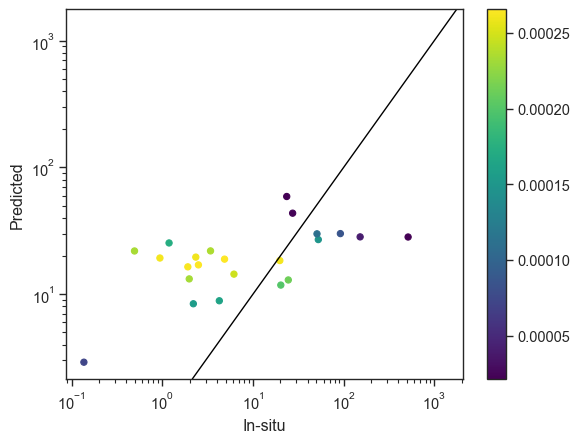

In [89]:
#%% LANDSAT GPB TRAINED MODEL PREDICTIONS ON HOLDOUT DATASET
# Predict response variable (pred_latent=False)
# pred_resp['response_mean']: mean predictions of the response variable 
# which combines predictions from the tree ensemble and the random effects
# pred_resp['response_var']: predictive (co-)variances (if predict_var=True)
pred_resp = gpb.predict(data=x_test, 
                                        group_data_pred=pd.DataFrame({'lake':lake_test}),
                                        group_rand_coef_data_pred = t_test,
                                        predict_var=False,
                                        pred_latent=False)

#extract predictions
preds_landsat_testset = pred_resp['response_mean']

#%% Plot prediction on test dataset (Landsat model)
#Test dataset = coincident Landsat+Sentinel data
#Using Landsat reflectance values
#https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib

values = np.vstack([y_test.ravel(), preds_landsat_testset.ravel()])
kernel = stats.gaussian_kde(values, bw_method= 0.5)(values)

plt.scatter(y_test, preds_landsat_testset, s=20, c=kernel,cmap='viridis')
plt.axline((0,0), (1300,1300), linewidth=1, color='black')
# plt.axis((0,100,0,100))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("In-situ")
plt.ylabel("Predicted")
plt.colorbar()
# plt.savefig('data/figures/gpboost/GPBoost_Landsat_coincident_data_holdout'+ time.strftime("%Y%m%d-%H%M%S")+ '.jpg', dpi=300)

evaluate(y_test, preds_landsat_testset, 'GPB_Landsat_testset') 

[GPBoost] [Warning] Unknown parameter: rmse-stdv
[GPBoost] [Warning] Unknown parameter: rmse-mean
[GPBoost] [Warning] Unknown parameter: experiment
[GPBoost] [Warning] Unknown parameter: mae-mean
[GPBoost] [Warning] Unknown parameter: mae-stdv
[GPBoost] [Warning] Unknown parameter: iterations
[GPBoost] [Warning] Unknown parameter: rmse-stdv
[GPBoost] [Warning] Unknown parameter: rmse-mean
[GPBoost] [Warning] Unknown parameter: experiment
[GPBoost] [Warning] Unknown parameter: mae-mean
[GPBoost] [Warning] Unknown parameter: mae-stdv
[GPBoost] [Warning] Unknown parameter: iterations
[GPBoost] [Info] Total Bins 52
[GPBoost] [Info] Number of data points in the train set: 28, number of used features: 9
[GPBoost] [Info] Start training from score 13.533185
Model Performance
Mean Deviation: -2.899
Mean Absolute Error: 8.514
RMSE: 80.027
Slope = 0.982
Pearson correlation = 0.965
r2 = 0.919


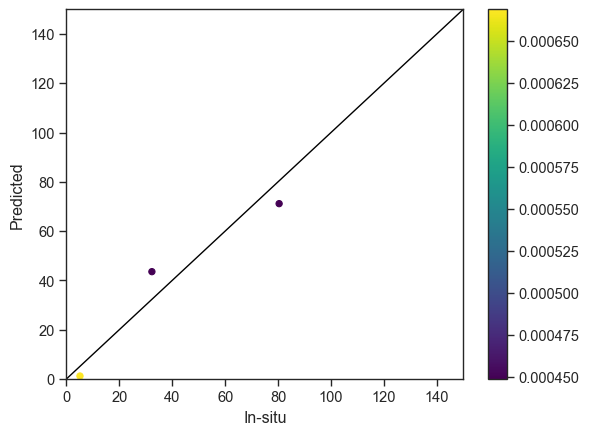

In [59]:
#%% LANDSAT GBM (NO RANDOM EFFECTS): TRAIN BEST MODEL

gbm = gpb.train(params=best_pars_gbm, 
                        train_set=data_train,  
                        num_boost_round=best_iter_index_gbm)

pred_resp_gbm = gbm.predict(data=x_test, predict_var=False, pred_latent=False)

evaluate_gbm = evaluate(y_test, pred_resp_gbm, 'GBM_Landsat')

values = np.vstack([y_test.ravel(), pred_resp_gbm.ravel()])
kernel = stats.gaussian_kde(values, bw_method= 0.5)(values)

plt.scatter(y_test, pred_resp_gbm, s=20, c=kernel, cmap='viridis')
plt.axline((0,0), (150,150), linewidth=1, color='black')
plt.axis((0,150,0,150))
plt.xlabel("In-situ")
plt.ylabel("Predicted")
plt.colorbar()
# plt.savefig('data/figures/gbm/GBM_Landsat_Coincident_holdout.jpg', dpi=300)